In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import pickle

Given that after EDA, we know that the data contains no null values, no abnomalies 

# 1. 🔍 Choosing the DL method

In [46]:
data = pd.read_csv('../Data/cleaned_data.csv')
df = data.copy()

In [47]:
print("Data types for each variable:")
print(df.dtypes, "\n")
print("Unique values of each variables:")
print(df.nunique())

Data types for each variable:
Country               object
Energy_Source         object
Monthly_Usage_kWh    float64
Year                 float64
Household_Size       float64
Income_Level           int64
Urban_Rural            int64
Adoption_Year        float64
Subsidy_Received       int64
Cost_Savings_USD     float64
dtype: object 

Unique values of each variables:
Country               25
Energy_Source          5
Monthly_Usage_kWh    995
Year                   5
Household_Size         8
Income_Level           3
Urban_Rural            2
Adoption_Year         15
Subsidy_Received       2
Cost_Savings_USD     989
dtype: int64


=> Country, Region, have a large number of unique values: 25 and 6

## a) Dealing with categorial data

After EDA we only keep 2 meaningful categorial columns: "Country" and "Energy Source"


A Consider 

If using one hot encoding => high dimensionality

if using label encoding => assign numerical significance to categorical variables

## b) Dealing with numerical data

### Examine the relationship between numerical columns

Covariance matrix:


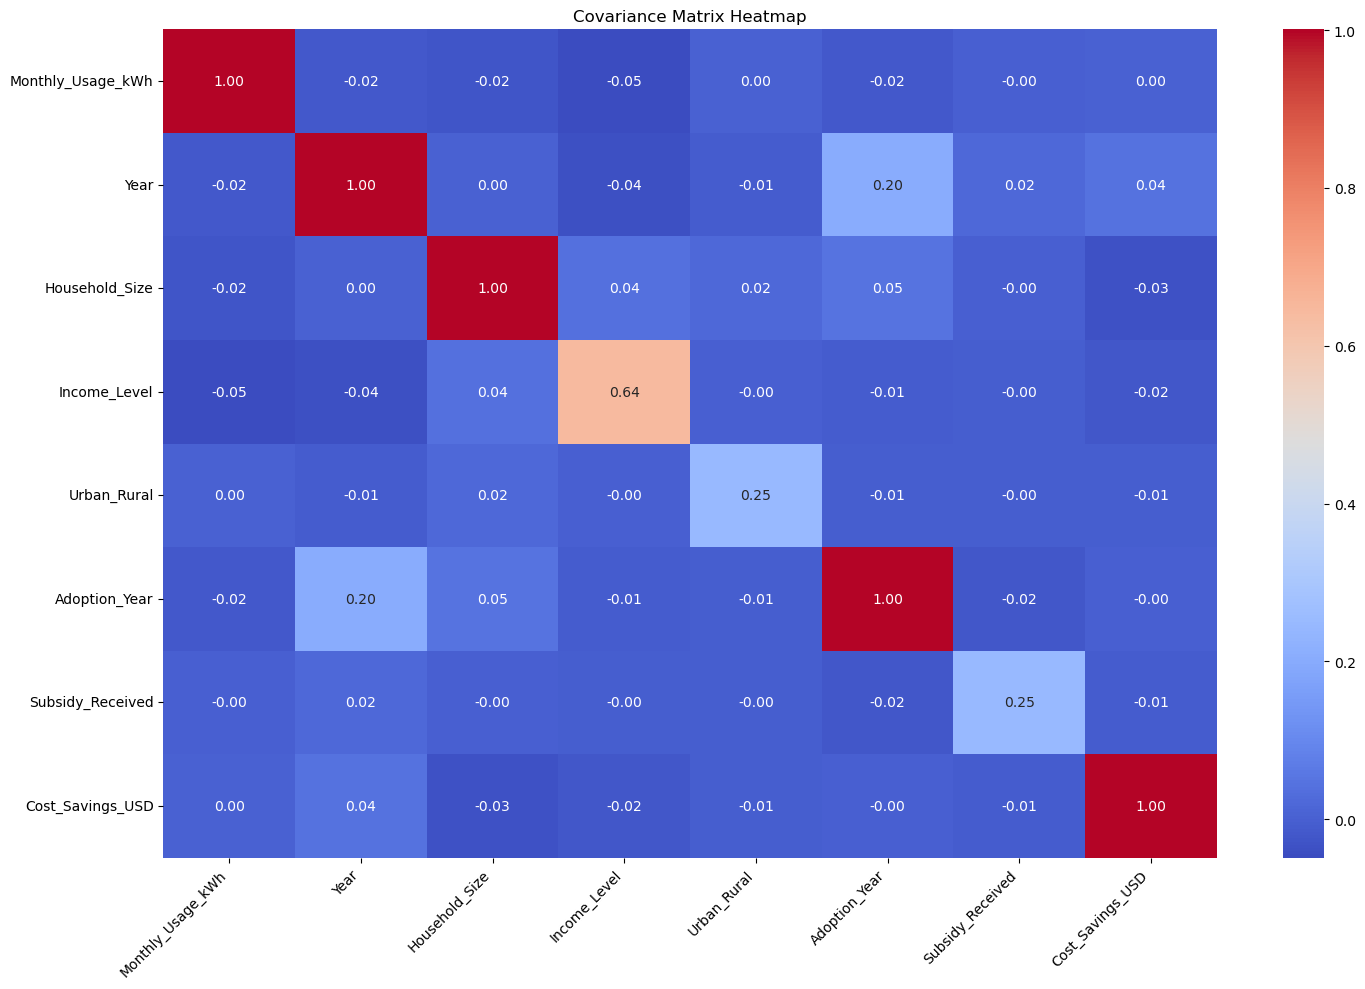

Correlation matrix:


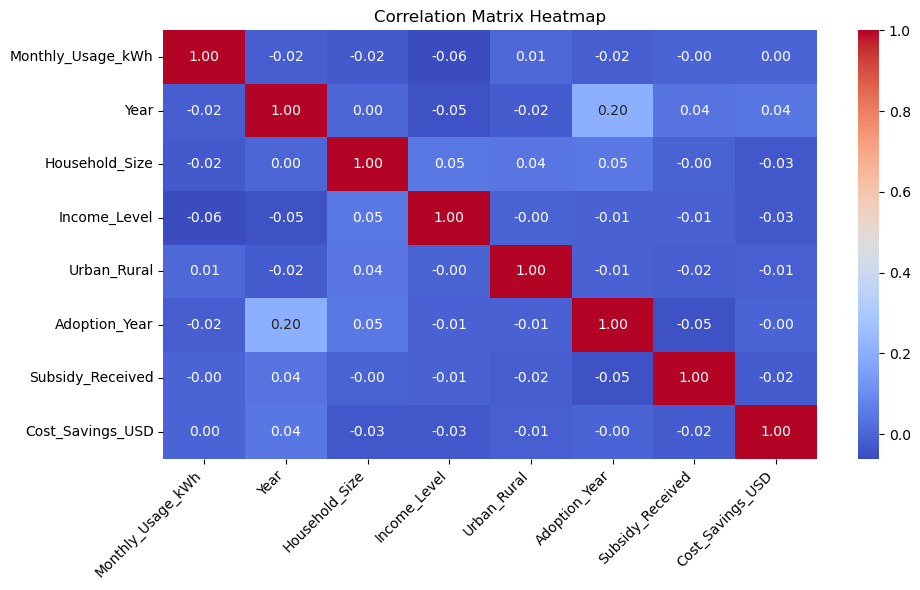

In [48]:
# Covariance matrix including categorical feature
print("Covariance matrix:")
heh= df.drop(columns= ["Country", "Energy_Source"])
covar_matrix= heh.cov()
plt.figure(figsize=(15, 10))
sns.heatmap(covar_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Covariance Matrix Heatmap")
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better fit
plt.yticks(rotation=0)               # Keep y-axis labels horizontal
plt.tight_layout()     
plt.show()


# Correlation matrix including categorical feature
print("Correlation matrix:")
corr_matrix= heh.corr()
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix Heatmap")
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better fit
plt.yticks(rotation=0)               # Keep y-axis labels horizontal
plt.tight_layout()     
plt.show()

From 2 figures we can see that the relationships among variables are weak (Values in the correlation matrix is near to 0), the data can be largely affected by other factors

=> Supervised learning methods would not be effective

# 2. ⚙️ Clustering with K-Prototypes

We choose K-Prototypes, a combination of K-Means(numerical data) and K-Modes(categorial data)

This method forms clusters by comparing the difference between data point to group close points together.

- For Numerical data, it compares using the Euclidean distance (K-means)
- For categorial data, it compares number of mismatches between categorical values (K-Modes)

K-Prototypes assigns weights to both types of features and calculates a weighted distance metric to determine cluster assignments

=> This means we dont have to encode the 2 types of data separately


## a) Making Clusters

In [49]:
from kmodes.kprototypes import KPrototypes

df = data.copy()

# Get the indices of numerical and categorial columnns
categorical_columns = df.select_dtypes(include=['object', 'category']).columns
categorical_indexes = [df.columns.get_loc(col) for col in categorical_columns]

### i) Choosing the right number of clusters(K)

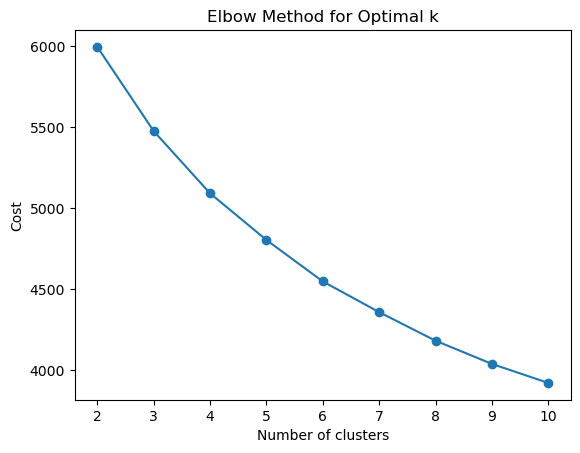

In [50]:
# Comparing the cost w.r.t the number of clusters

costs = []
for k in range(2, 11):
    kp = KPrototypes(n_clusters=k, init='Cao', verbose=0)
    kp.fit_predict(df.to_numpy(), categorical=categorical_indexes)
    costs.append(kp.cost_)

plt.plot(range(2, 11), costs, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Cost')
plt.title('Elbow Method for Optimal k')
plt.show()


==> We choose K=10 for the lower cost, higher number of k would further reduce the cost but lead to overfitting

### ii) Building the final model

In [51]:
# Perform K-prototype clustering
kproto = KPrototypes(n_clusters=10, init='Cao', verbose=0, random_state=27)
clusters = kproto.fit_predict(df.to_numpy(), categorical=categorical_indexes)

## b) Displaying clusters info

In [52]:
numerical_columns = df.select_dtypes(exclude=['object', 'category']).columns
# Find correct order of the columns name because kprototype change it 
correct_column_order = list(numerical_columns) + list(categorical_columns) 

# Turn clusters into DataFrame
centroids_df = pd.DataFrame(kproto.cluster_centroids_, columns=correct_column_order)

# Round up float data for certain columns
columns_to_round = ["Year", "Adoption_Year"]  
centroids_df[columns_to_round] = centroids_df[columns_to_round].astype(float).round(0).astype(int)
columns_to_round = ["Monthly_Usage_kWh", "Cost_Savings_USD", "Household_Size"]  
centroids_df[columns_to_round] = centroids_df[columns_to_round].astype(float).round(2)

# Display the clusters
centroids_df.index = [f'Cluster {i}' for i in range(kproto.n_clusters)]
centroids_df

,Monthly_Usage_kWh,Year,Household_Size,Income_Level,Urban_Rural,Adoption_Year,Subsidy_Received,Cost_Savings_USD,Country,Energy_Source
Cluster 0,-0.91,-1,-0.88,1.4137931034482758,0.42528735632183906,0,0.4482758620689655,-0.72,Japan,Solar
Cluster 1,0.79,1,0.77,0.9711538461538461,0.5,1,0.38461538461538464,0.89,Colombia,Biomass
Cluster 2,0.51,-1,1.01,0.9724770642201835,0.5596330275229358,0,0.5045871559633027,-0.64,New Zealand,Wind
Cluster 3,0.10,1,-0.61,0.8817204301075269,0.3978494623655914,-1,0.5806451612903226,0.91,Australia,Solar
Cluster 4,1.05,0,-0.86,0.8990825688073395,0.43119266055045874,0,0.45871559633027525,-0.86,Australia,Hydro
Cluster 5,-0.54,1,-0.81,1.1101694915254237,0.559322033898305,1,0.5,0.24,Australia,Wind
Cluster 6,-0.30,1,0.61,1.1,0.5363636363636364,-1,0.5545454545454546,-0.69,Australia,Hydro
Cluster 7,-0.29,1,0.78,0.8953488372093024,0.3953488372093023,1,0.6046511627906976,-0.83,New Zealand,Geothermal
Cluster 8,0.73,-1,-0.78,0.8947368421052632,0.5394736842105263,0,0.5,1.07,New Zealand,Wind
Cluster 9,-1.06,-1,0.53,1.0277777777777777,0.48148148148148145,0,0.4537037037037037,0.82,New Zealand,Biomass


In [53]:
with open("../EDA & Preprocessing/scaler.pkl", "rb") as f:
    scaler = pickle.load(f)

num_cols = ['Monthly_Usage_kWh', 'Household_Size', 'Cost_Savings_USD', 'Adoption_Year', 'Year']
ord_cols = ['Income_Level', 'Urban_Rural', 'Subsidy_Received']
cat_cols = ['Country', 'Energy_Source']
cluster_scaled_data = centroids_df[num_cols]

cluster_unscaled = pd.DataFrame(scaler.inverse_transform(cluster_scaled_data), 
                                columns=num_cols, index=cluster_scaled_data.index)

income_reverse_map = {0: 'Low', 1: 'Middle', 2: 'High'}
urban_reverse_map = {1: 'Urban', 0: 'Rural'}
subsidy_reverse_map = {1: 'Yes', 0: 'No'}

for i in num_cols:
    cluster_unscaled[i] = cluster_unscaled[i].astype(float).round().astype(int)


cluster_unscaled['Income_Level'] = centroids_df['Income_Level'].astype(float).round().astype(int).map(income_reverse_map)
cluster_unscaled['Urban_Rural'] = centroids_df['Urban_Rural'].astype(float).round().astype(int).map(urban_reverse_map)
cluster_unscaled['Subsidy_Received'] = centroids_df['Subsidy_Received'].astype(float).round().astype(int).map(subsidy_reverse_map)

cluster_unscaled = pd.concat([cluster_unscaled, centroids_df[cat_cols]], axis=1)
cluster_unscaled

,Monthly_Usage_kWh,Household_Size,Cost_Savings_USD,Adoption_Year,Year,Income_Level,Urban_Rural,Subsidy_Received,Country,Energy_Source
Cluster 0,386,2,145,2016,2021,Middle,Rural,No,Japan,Solar
Cluster 1,1099,6,376,2020,2023,Middle,Rural,No,Colombia,Biomass
Cluster 2,981,7,157,2016,2021,Middle,Urban,Yes,New Zealand,Wind
Cluster 3,809,3,379,2012,2023,Middle,Rural,Yes,Australia,Solar
Cluster 4,1208,3,125,2016,2022,Middle,Rural,No,Australia,Hydro
Cluster 5,541,3,283,2020,2023,Middle,Urban,No,Australia,Wind
Cluster 6,641,6,150,2012,2023,Middle,Urban,Yes,Australia,Hydro
Cluster 7,646,6,130,2020,2023,Middle,Rural,Yes,New Zealand,Geothermal
Cluster 8,1074,3,401,2016,2021,Middle,Urban,No,New Zealand,Wind
Cluster 9,323,6,366,2016,2021,Middle,Rural,No,New Zealand,Biomass


## c) Evaluation

### i) Silhouette Score (numerical only)

In [54]:
from sklearn.metrics import silhouette_score

# Get cluster labels and numerical subset
labels = kproto.labels_
numerical_data = data.select_dtypes(include=['int64', 'float64'])

score = silhouette_score(numerical_data, labels)
print("Silhouette score ranges from -1 to 1; closer to 1 means well-separated clusters.\n")
print("Silhouette Score:", score)

Silhouette score ranges from -1 to 1; closer to 1 means well-separated clusters.

Silhouette Score: 0.12620898515871068


### ii) Clusters distribution

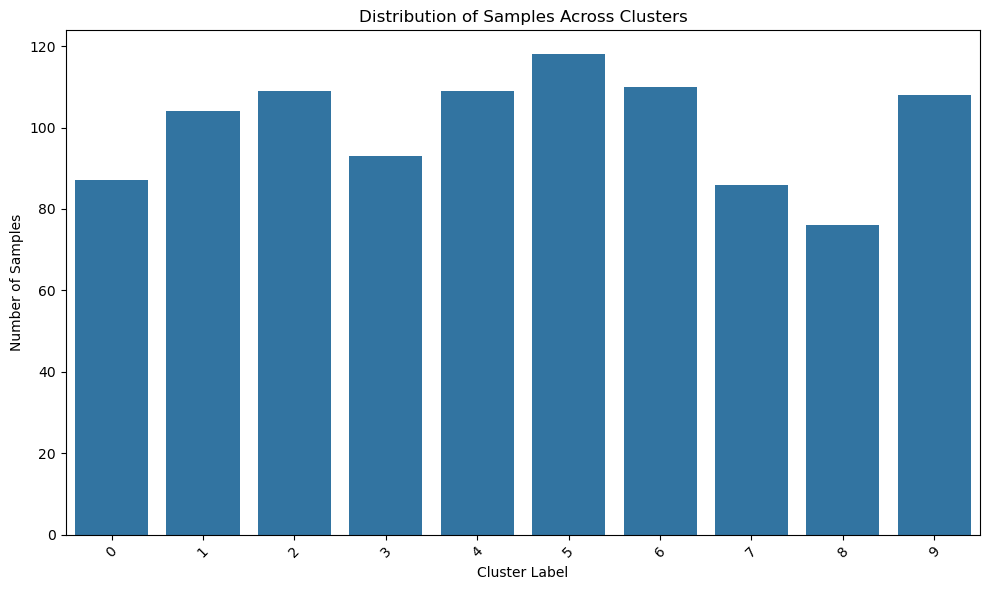

In [55]:
data['Cluster'] = labels

# Plot the distribution
plt.figure(figsize=(10, 6))
sns.countplot(x='Cluster', data=data)
plt.title("Distribution of Samples Across Clusters")
plt.xlabel("Cluster Label")
plt.ylabel("Number of Samples")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

==> A relatively balanced distribution

## d) Making predictions

In [56]:
from utils import encode_df

# Assign a name for each cluster
cluster_labels = {
    0: "Heavy Users in Underserved Areas",
    1: "High Impact Rural Households",
    2: "Minimal Users with Strong Means",
    3: "Urban Subsidized Adopters",
    4: "Budget-Conscious Urban Beneficiaries",
    5: "Efficient Urban Savers",
    6: "High Consumers with Low Returns",
    7: "Frugal Households with High Gains",
    8: "Urban Energy Spenders",
    9: "Wealthy Subsidized Consumers"
}
columns = df.columns.tolist()


sample = pd.DataFrame([{
    "Monthly_Usage_kWh": 950.0,
    "Year": 2022,
    "Household_Size": 4.6,
    "Adoption_Year": 2017,
    "Cost_Savings_USD": 300.0,
    "Country": "Australia",
    "Energy_Source": "Solar",
    "Income_Level": "Middle",
    "Urban_Rural": "Urban",
    "Subsidy_Received": "Yes"
}])[columns]  # ensure correct column order

cluster_id = kproto.predict(encode_df(sample).to_numpy(), categorical=categorical_indexes)[0]
user_label = cluster_labels[cluster_id]
print(f"Cluster {cluster_id}: {user_label}")

Cluster 6: High Consumers with Low Returns


## e) Saving the model

In [57]:
with open("K_Prototypes.pkl", "wb") as f:
    pickle.dump(kproto, f)